# Implémentation d'un Classificateur Non Supervisé basé sur le modèle PaintAttnNet pour la détection de crises d'épilepsie - 2nd Méthode

Ce Jupyter notebook permet l'implémentation de l'encodeur PaintAttnNet et d'un décodeur dans le cadre d'un apprentissage non supervisé. 
L'objectif est: apprentissage (reconstruction) sur les signaux non épileptiques et classification par analyse de la fonction de coût du modèle appliqué à des signaux issus de crises d'épilepsie et non issus de crises d'épilepsie

### Importation des bibliothèques utilisées

In [18]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, random_split
from scipy.signal import butter, filtfilt
from sklearn.model_selection import train_test_split  
import numpy as np   
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchsummary import summary
from sklearn.preprocessing import StandardScaler


import torch.nn.functional as F
import copy
from copy import deepcopy
from math import sqrt

# Fixer les graines pour la reproductibilité
torch.manual_seed(65487)
np.random.seed(65487)

# Afficher les versions des bibliothèques utilisées
print(f"Version de PyTorch : {torch.__version__}")
print(f"Version de Torchvision : {torchvision.__version__}")
print(f"Version de Numpy : {np.__version__}")


Version de PyTorch : 2.5.1
Version de Torchvision : 0.20.1
Version de Numpy : 1.26.4


### Définition de la fonction qui créé les masques

In [19]:
    
def geom_noise_mask_single(L, lm, masking_ratio):
    """
    Crée aléatoirement un masque booléen de longueur `L`, constitué de sous-séquences de longueur moyenne lm, masquant avec des 0 une proportion `masking_ratio`
    de la séquence L. La longueur des sous-séquences de masquage et des intervalles suit une distribution géométrique.
    Args:
        L: longueur du masque et de la séquence à masquer
        lm: longueur moyenne des portions de masquage (séries de 0)
        masking_ratio: proportion de L à masquer

    Returns:
        tenseur booléen de forme (L,) destiné à masquer ('drop') avec des 0 une séquence de longueur L
    """
    keep_mask = torch.ones(L, dtype=torch.bool)
    p_m = 1 / lm  # probabilité que chaque séquence de masquage s'arrête. paramètre de la distribution géométrique.
    p_u = p_m * masking_ratio / (1 - masking_ratio)  # probabilité que chaque séquence non masquée s'arrête. paramètre de la distribution géométrique.
    p = [p_m, p_u]

    # Commencer dans l'état 0 avec une probabilité masking_ratio
    state = int(torch.rand(1).item() > masking_ratio)  # l'état 0 signifie masquage, 1 signifie non masquage
    for i in range(L):
        keep_mask[i] = state  # ici, il se trouve que l'état et la valeur de masquage correspondant à l'état sont identiques
        if torch.rand(1).item() < p[state]:
            state = 1 - state

    return keep_mask


---
---
# Importation et formatage des données pour l'entraînement

### Importation, filtrage et création du Dataset avec les signaux masqués

Les données ont été extraites de la base de données et rangées dans l'ordre en fonction du set dont elles proviennent dans le fichier "data.pkl" (les 100 signaux du set A, puis les 100 du set B, etc. jusqu'à E). À chaque signal, on a ajouté au début son label correspondant (A => 1, B => 2, etc.).

Après avoir importé les données, et selon les spécifications de la base de données, il est conseillé de filtrer les signaux avec un filtre passe-bande de f1 = 0.53 Hz et f2 = 40 Hz.

Une fois les signaux filtrés, ils sont ajoutés à un Dataset personnalisé qui attribue les bons labels en fonction du set d'où ils proviennent et de la classification souhaitée. Ce Dataset applique aussi des masques aléatoires aux signaux à chaque fois qu'ils sont appelés à l'aide du \_\_getitem\_\_ grace à la fonction "m_noise_mask_single".

In [20]:
# Charger les données depuis le fichier data.pkl dans un tensor
with open('data.pkl', 'rb') as file:
    data = pickle.load(file)

# Séparer les labels des données
labels = data[:, 0]  # La première colonne correspond aux labels
signals = data[:, 1:]  # Les colonnes restantes sont les données à filtrer

# Définir les fréquences de coupure et la fréquence d'échantillonnage du signal
low_cutoff = 0.53
high_cutoff = 40
sample_rate = 173.61

# Conception du filtre passe-bande
nyquist = 0.5 * sample_rate
low = low_cutoff / nyquist
high = high_cutoff / nyquist
b, a = butter(4, [low, high], btype='band')

# Appliquer le filtre passe-bande aux données
filtered_signals = filtfilt(b, a, signals, axis=1)

# Faire une copie des signaux filtrés pour éviter les strides négatifs
filtered_signals = filtered_signals.copy()

# Normalisation des signaux
def normalize_minmax(signals):
    # Soustraction de la moyenne
    mean = signals.mean(axis=1, keepdims=True)
    signals = signals - mean

    # Division par l'écart-type 
    std = signals.std(axis=1, keepdims=True)
    std[std == 0] = 1e-8  # Éviter la division par zéro
    normalized = signals / std

    return normalized

# Normalisation des signaux filtrés
filtered_signals = normalize_minmax(filtered_signals)

# Définir la classe du dataset avec masquage
class EEGImputationDataset(torch.utils.data.Dataset):
    def __init__(self, signals, labels, mean_mask_length, masking_ratio):
        self.signals = signals
        self.labels = labels
        self.masking_ratio = masking_ratio
        self.mean_mask_length = mean_mask_length

    def __getitem__(self, idx):
        # Récupérer le signal et le label
        x = self.signals[idx]
        label = self.labels[idx] if self.labels is not None else None
        
        # Convertir en tenseur si nécessaire
        if not torch.is_tensor(x):
            x = torch.tensor(x, dtype=torch.float32)
        
        # Créer une copie du signal original
        x_original = x.clone()
        
        # Générer le masque de bruit
        mask = geom_noise_mask_single(
            x.shape[0],
            masking_ratio=self.masking_ratio,
            lm=self.mean_mask_length
        )
        
        # S'assurer que le masque est un tenseur
        mask = mask.float()
        
        # Appliquer le masque au signal
        x_masked = x * mask
        
        # Ajouter une dimension pour le canal si nécessaire
        x_masked = x_masked.unsqueeze(0) if len(x_masked.shape) == 1 else x_masked
        mask = mask.unsqueeze(0) if len(mask.shape) == 1 else mask
        x_original = x_original.unsqueeze(0) if len(x_original.shape) == 1 else x_original
        
        if label is not None:
            label = torch.tensor(label)
        
        return x_masked, mask, x_original, label

    def __len__(self):
        return len(self.signals)

# Créer un dataset personnalisé avec masquage
dataset = EEGImputationDataset(
    signals=filtered_signals, 
    labels=labels,
    mean_mask_length=3, # Longueur moyenne des portions de masquage
    masking_ratio=0.2, # Proportion du signal à masquer
)


### Comparaison visuelle du signal filtré et original

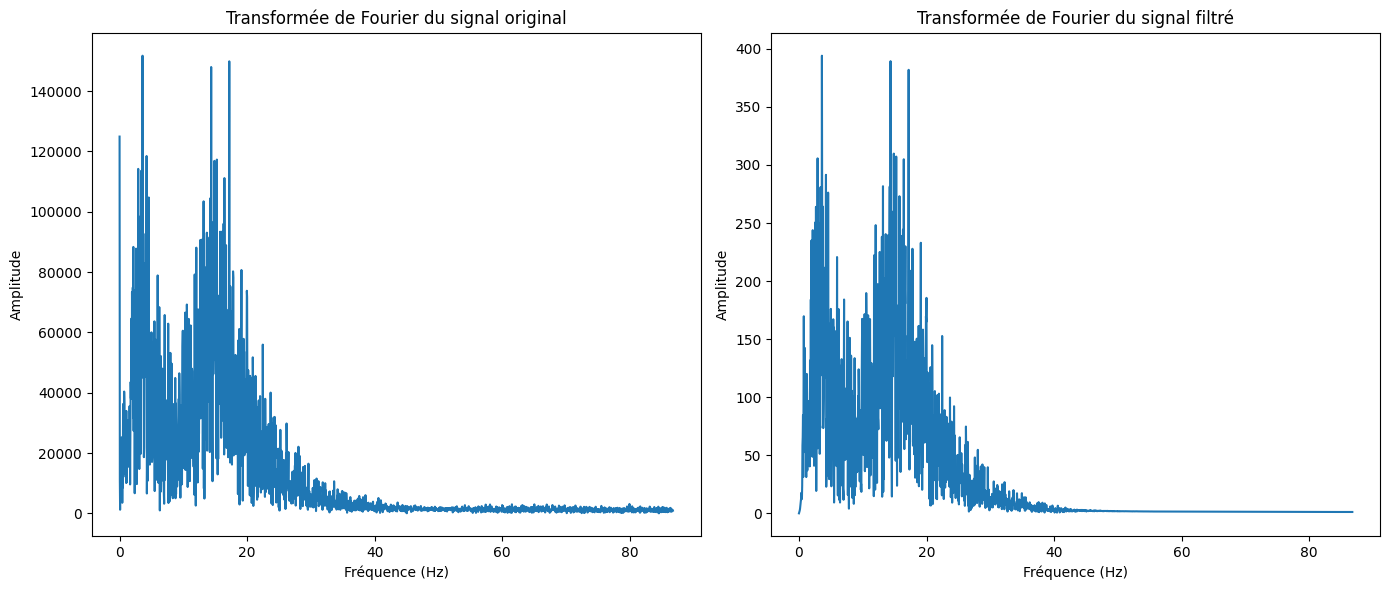

In [21]:
# Transformée de Fourier d'un des signaux filtrés et de sa version originale

# Sélectionner un signal aléatoire
random_index = np.random.randint(0, data.shape[0])
original_signal = data[random_index]
filtered_signal = filtered_signals[random_index]

# Calculer la transformée de Fourier 
original_fft = np.fft.fft(original_signal)
filtered_fft = np.fft.fft(filtered_signal)

# Calculer les fréquences correspondantes
freqs = np.fft.fftfreq(len(original_signal), d=1/sample_rate)

# Ajuster les longueurs pour correspondre
half_n = len(original_signal) // 2
freqs = freqs[:half_n]
original_fft = original_fft[:half_n]
filtered_fft = filtered_fft[:half_n]

# Afficher les résultats
plt.figure(figsize=(14, 6))

# Transformée de Fourier du signal original
plt.subplot(1, 2, 1)
plt.plot(freqs, np.abs(original_fft))
plt.title('Transformée de Fourier du signal original')
plt.xlabel('Fréquence (Hz)')
plt.ylabel('Amplitude')

# Transformée de Fourier du signal filtré
plt.subplot(1, 2, 2)
plt.plot(freqs, np.abs(filtered_fft))
plt.title('Transformée de Fourier du signal filtré')
plt.xlabel('Fréquence (Hz)')
plt.ylabel('Amplitude')

plt.tight_layout()
plt.show()

## Diviser les données en ensembles d'entraînement, de validation et de test

Le modèle ne doit s'entraîner que sur les signaux qui ne correspondent pas à des crises d'épilepsie 

Pour ne pas biaiser le modèle, les bases de données de validation et de test ont autant de signaux épileptiques que non épileptiques (40 de chaque type)

In [22]:
# Calculer les tailles pour la division
train_size = int(0.8 * 100)  # 80 échantillons
val_size = int(0.1 * 100)    # 10 échantillons par classe
test_size = 100 - train_size - val_size  # Échantillons restants par classe

# Initialiser des listes vides pour chaque division
train_data_list = []
val_data_list = []
test_data_list = []

# Diviser chaque classe séparément et combiner
for set_start in range(0, len(dataset), 100):  # Chaque ensemble a 100 échantillons
    set_data = torch.utils.data.Subset(dataset, range(set_start, set_start + 100))
    if set_start <= 300:  # train_data_list prend seulement les signaux non épileptiques
        class_splits = random_split(set_data, [train_size, val_size, test_size])
        train_data_list.append(class_splits[0])
        val_data_list.append(class_splits[1])
        test_data_list.append(class_splits[2])
    else:
        class_splits = random_split(set_data, [0.4, 0.4, 0.2])  # partager en 2 les signaux épileptiques dans val_data_list et test_data_list
        val_data_list.append(class_splits[0]) 
        test_data_list.append(class_splits[1])

# Combiner les divisions en utilisant ConcatDataset
train_data = torch.utils.data.ConcatDataset(train_data_list)
val_data = torch.utils.data.ConcatDataset(val_data_list)
test_data = torch.utils.data.ConcatDataset(test_data_list)

# Créer des DataLoaders
batch_size = 1  # taille du batch
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

print("Ensemble d'entraînement :", len(train_data))
print("Ensemble de validation :", len(val_data))
print("Ensemble de test :", len(test_data))


Ensemble d'entraînement : 320
Ensemble de validation : 80
Ensemble de test : 80


### Visulation d'un signal et sa version masquée

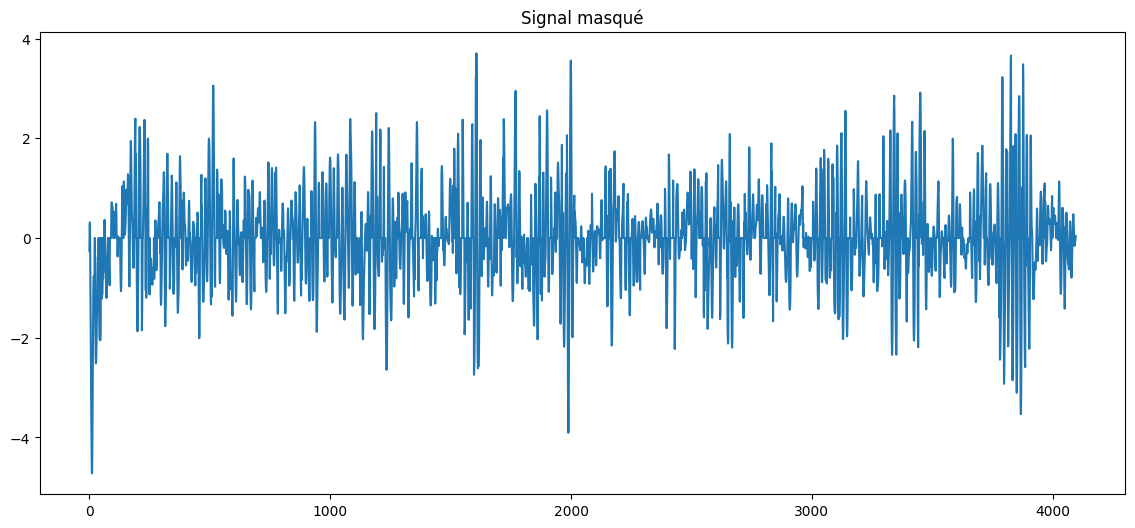

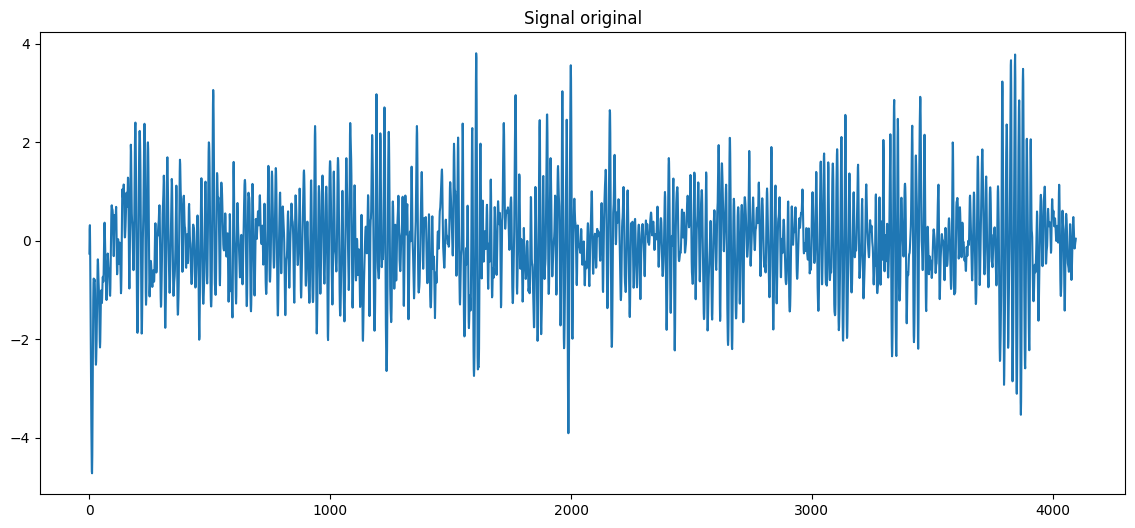

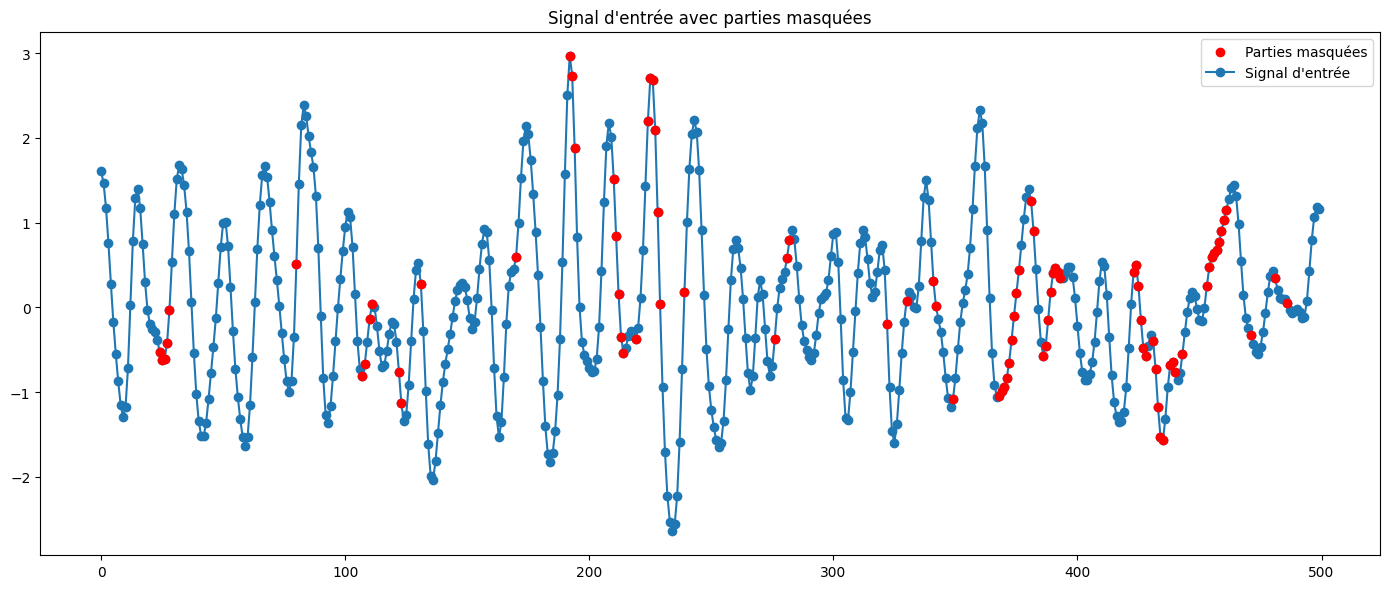

Rapport de 0 par rapport au reste : [0.17939956]


In [23]:
# Sélectionner un batch aléatoire de signaux d'entraînement
dataiter = iter(train_loader)
x_masked, mask, x, labels = next(dataiter)

# Comparaison entre x_masked et x pour un signal aléatoire
random_index = np.random.randint(0, x_masked.shape[0])
signal = x_masked[random_index].squeeze().cpu().numpy()
original_signal = x[random_index].squeeze().cpu().numpy()

# Affichage des signaux masqués et originaux sur deux graphiques différents
plt.figure(figsize=(14, 6))
plt.plot(signal.T)
plt.title("Signal masqué")
plt.show()

plt.figure(figsize=(14, 6))
plt.plot(original_signal.T)
plt.title("Signal original")
plt.show()

# Afficher un signal d'entrée au hasard et ses parties masquées
random_index = np.random.randint(0, x.shape[0])
input_signal = x[random_index].squeeze().cpu().numpy()
mask_signal = mask[random_index].cpu().numpy().squeeze()

plt.figure(figsize=(14, 6))

# Afficher les parties masquées en rouge
masked_indices = np.where(mask_signal[1000:1500] == 0)[0]
plt.scatter(masked_indices, input_signal[masked_indices + 1000], color='red', label='Parties masquées', zorder=3)

# Afficher le signal d'entrée avec les parties masquées
plt.plot(input_signal[1000:1500], marker='o', label='Signal d\'entrée', zorder=1)
plt.title("Signal d'entrée avec parties masquées")
plt.legend()

plt.tight_layout()
plt.show()

# Calculer et afficher le rapport du nombre de 0 par rapport au reste sur les signaux masqués
num_zeros = (x_masked == 0).sum(dim=2).sum(dim=1).cpu().numpy()  # Nombre de 0 dans chaque signal masqué
num_total = x_masked.shape[2]  # Nombre total de valeurs dans chaque signal
zero_ratio = num_zeros / num_total  # Rapport de 0 par rapport au reste

print("Rapport de 0 par rapport au reste :", zero_ratio)

---
---
# Définition de l'architecture du réseau

### Définition du modèle PainAttnNet

Le code ci-dessous a été récupéré sur Github et adapté à notre problème. 

Voici le lien du Github : https://github.com/zhenyuanlu/PainAttnNet 

In [24]:
#Modèle MSCN (réseau de neurones à convolution multi-échelle)
class MSCN(nn.Module):
    def __init__(self, mscn_output_channels, model_dim, kernel_size_short, kernel_size_medium, kernel_size_long, stride_short, stride_medium, stride_long):
        super().__init__()
        dropout = 0.5

        # Définition de la branche à courte échelle
        self.short_scale = nn.Sequential(
            nn.Conv1d(1, mscn_output_channels, kernel_size_short, stride_short, dilation=1, bias=False, padding=9),
            nn.BatchNorm1d(mscn_output_channels),
            nn.GELU(),
            nn.MaxPool1d(kernel_size=8, stride=2, padding=4),
            nn.Dropout(dropout),
            nn.Conv1d(mscn_output_channels, 128, kernel_size=8, stride=1, bias=False, padding=4),
            nn.BatchNorm1d(128),
            nn.GELU(),
            nn.Conv1d(128, mscn_output_channels, kernel_size=8, stride=1, bias=False, padding=4),
            nn.BatchNorm1d(mscn_output_channels),
            nn.GELU(),
            nn.MaxPool1d(kernel_size=4, stride=4, padding=2)
        )

        # Définition de la branche à échelle moyenne
        self.medium_scale = nn.Sequential(
            nn.Conv1d(1, mscn_output_channels, kernel_size_medium, stride_medium, dilation=1, bias=False, padding=38),
            nn.BatchNorm1d(mscn_output_channels),
            nn.GELU(),
            nn.MaxPool1d(kernel_size=4, stride=4, padding=0),
            nn.Dropout(dropout),
            nn.Conv1d(mscn_output_channels, 128, kernel_size=4, stride=1, bias=False, padding=3),
            nn.BatchNorm1d(128),
            nn.GELU(),
            nn.Conv1d(128, mscn_output_channels, kernel_size=4, stride=1, bias=False, padding=3),
            nn.BatchNorm1d(mscn_output_channels),
            nn.GELU(),
            nn.MaxPool1d(kernel_size=2, stride=2, padding=1)
        )

        # Définition de la branche à longue échelle
        self.long_scale = nn.Sequential(
            nn.Conv1d(1, mscn_output_channels, kernel_size_long, stride_long, dilation=1, bias=False, padding=67),
            nn.BatchNorm1d(mscn_output_channels),
            nn.GELU(),
            nn.MaxPool1d(kernel_size=8, stride=8, padding=0),
            nn.Dropout(dropout),
            nn.Conv1d(mscn_output_channels, 128, kernel_size=8, stride=1, bias=False, padding=3),
            nn.BatchNorm1d(128),
            nn.GELU(),
            nn.Conv1d(128, mscn_output_channels, kernel_size=8, stride=1, bias=False, padding=3),
            nn.BatchNorm1d(mscn_output_channels),
            nn.GELU(),
            nn.MaxPool1d(kernel_size=2, stride=2, padding=1)
        )

        # Tester les dimensions de sortie pour les couches fully connected
        x_short_test = self.short_scale(torch.randn(1, 1, 4097))
        x_medium_test = self.medium_scale(torch.randn(1, 1, 4097))
        x_long_test = self.long_scale(torch.randn(1, 1, 4097))

        self.dropout = nn.Dropout(dropout)
        self.fc_short = nn.Linear(x_short_test.shape[2], model_dim)
        self.fc_medium = nn.Linear(x_medium_test.shape[2], model_dim)
        self.fc_long = nn.Linear(x_long_test.shape[2], model_dim)

    def forward(self, x):
        # Passer les données à travers les branches à différentes échelles
        x_short1 = self.short_scale(x)
        x_medium1 = self.medium_scale(x)
        x_long1 = self.long_scale(x)

        # Passer les sorties des branches à travers les couches fully connected
        x_short2 = self.fc_short(x_short1)
        x_medium2 = self.fc_medium(x_medium1)
        x_long2 = self.fc_long(x_long1)

        # Concatenation des sorties
        x_concat = torch.cat((x_short2, x_medium2, x_long2), dim=1)

        # Appliquer le dropout
        x_concat = self.dropout(x_concat)

        return x_concat, x_short1, x_medium1, x_long1


In [25]:
# Modèle SEResNet (Réseau résiduel avec blocs de compression et excitation)

"""
Ce module contient l'implémentation de l'architecture SEResNet.
"""

# Tout d'abord, nous définissons le bloc de compression et excitation.
class SENet(nn.Module):
    """
    Bloc de compression et excitation pour l'attention par canal.
    """

    # Tout d'abord, l'entrée est moyennée à l'aide d'une couche de pooling adaptatif pour créer une seule valeur par canal.
    # Ensuite, deux couches entièrement connectées sont utilisées pour créer les poids d'attention.
    # Enfin, l'entrée est multipliée par les poids d'attention pour créer la sortie.
    def __init__(self, channel, reduction=16): 
        super(SENet, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Sequential( # Créer les couches entièrement connectées
            nn.Linear(channel, channel // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1)
        return x * y.expand_as(x) # Multiplier l'entrée par les poids d'attention


# Ensuite, nous définissons le bloc de construction qui prépare l'entrée avant de l'envoyer au bloc SE et ajoute l'entrée globale à la sortie du bloc SE.
class SEBasicBlock(nn.Module):
    """
    Bloc de construction de base pour les réseaux de compression et excitation avec d'autres couches.
    """
    expansion = 1

    # Le bloc se compose de deux couches convolutionnelles avec normalisation par lots et fonctions d'activation ReLU.
    def __init__(self, input_channels, output_channels, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None,
                 *, reduction=16):
        super(SEBasicBlock, self).__init__()
        self.conv1 = nn.Conv1d(input_channels, output_channels, stride)
        self.bn1 = nn.BatchNorm1d(output_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv1d(output_channels, output_channels, 1)
        self.bn2 = nn.BatchNorm1d(output_channels)
        self.se = SENet(output_channels, reduction) # Envoyer la sortie dans le bloc SE
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        # Première couche convolutionnelle
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        # Deuxième couche convolutionnelle
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.se(out)

        # Rééchantillonner si nécessaire
        if self.downsample is not None:
            residual = self.downsample(x)

        # Ajouter la connexion résiduelle et appliquer ReLU
        out += residual
        out = self.relu(out)

        return out


# Enfin, nous créons l'architecture ResNet avec un nombre 'blocks_size' d'instances de SEBasicBlock mises bout à bout.
class SEResNet(nn.Module):
    """
    Réseau résiduel avec blocs de compression et excitation

    Le rééchantillonnage est effectué par conv1 lorsque stride != 1 ou
    la taille des input_channels n'est pas égale à la taille de sortie.
    """
    def __init__(self, output_channels, block_size, mscn_output_channels_times3):
        super(SEResNet, self).__init__()
        self.input_channels = mscn_output_channels_times3 # Nombre de cartes de caractéristiques en entrée
        self.block = SEBasicBlock 
        self.layer = self._make_layer(self.block, output_channels, block_size)

    # Créer une couche avec un nombre 'blocks' d'instances de SEBasicBlock.
    def _make_layer(self, block, output_channels, blocks, stride = 1):
        downsample = self._downsample_layer(self.input_channels, output_channels * block.expansion, stride) # Rééchantillonner si nécessaire

        layers = [block(self.input_channels, output_channels, stride, downsample)] # Créer le premier bloc avec rééchantillonnage si nécessaire
        self.input_channels = output_channels * block.expansion # Mettre à jour le nombre de cartes de caractéristiques en fonction de l'expansion du bloc
        layers.extend(block(self.input_channels, output_channels) for _ in range(1, blocks)) # Créer le reste des blocs

        return nn.Sequential(*layers)

    @staticmethod
    def _downsample_layer(input_channels, output_channels, stride):
        if stride != 1 or input_channels != output_channels:
            return nn.Sequential(
                nn.Conv1d(input_channels, output_channels,
                          kernel_size = 1, stride = stride, bias = False),
                nn.BatchNorm1d(output_channels)
            )
        return None

    def forward(self, x):
        return self.layer(x)


In [26]:
# Modèle TransformerEncoder (Encodeur Transformer)

# La classe EncoderWrapper englobe tout :
# Elle appelle plusieurs couches de "TransformerEncoder", TransformerEncoder qui prend en entrée un MultiHeadAttention et un MLP
# Le SublayerOutput prend ensuite en entrée les MultiHeadAttention et MLP et applique le modèle
# Donc : EncoderWrapper --> TransformerEncoder --> SublayerOutput --> Convolution, MultiHeadAttention, MLP et ce multiple fois

# Fonction utilitaire
def clones(module, N): 
    """
    Génère N couches identiques

    Args:
        module (nn.Module): Module PyTorch à cloner
        N (int): Nombre de clones à créer

    Returns:
        nn.ModuleList: Liste de N modules PyTorch clonés
    """
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])


class TCN(nn.Module):
    """
    Réseau de Convolution Temporelle avec padding causal, connexions résiduelles et normalisation par lot

    """
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, dilation=1, causal=True):
        super(TCN, self).__init__()
        padding = (kernel_size - 1) * dilation if causal else 0
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size, stride, padding, dilation)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size, stride, padding, dilation)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.relu = nn.ReLU()
        self.causal = causal
        self.tcn_padding = padding
        self.downsample = None

        if in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv1d(in_channels, out_channels, 1),
                nn.BatchNorm1d(out_channels)
            )

    def forward(self, x):
        residual = x
        out = self.relu(self.bn1(self.conv1(x)))

        if self.causal:
            out = out[:, :, :-self.tcn_padding] 

        out = self.bn2(self.conv2(out))

        if self.causal:
            out = out[:, :, :-self.tcn_padding]

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class MultiHeadAttention(nn.Module):
    def __init__(self, num_heads, model_dim, se_reduced_size, dropout=0.1):
        super(MultiHeadAttention, self).__init__()
        self.tcn = clones(TCN(se_reduced_size, se_reduced_size, kernel_size=7), 2)
        # Si batch_first=True est défini pour nn.MultiheadAttention()
        # alors les tenseurs d'entrée et de sortie sont fournis sous la forme (batch, seq, feature(channels))
        self.multihead_attention = nn.MultiheadAttention(se_reduced_size, num_heads, batch_first=True,
                                                         dropout=dropout)

    def forward(self, query, key, value):
        """
        Nous échangeons les dimensions seq et channel pour les tenseurs d'entrée afin
        de répondre aux exigences de nn.MultiheadAttention()
        par exemple BioVid, (batch_size=128, seq_len=75, out_channels=30)
        :return: dimension (batch_size, out_channels, seq_len)
        """
        query = query.transpose(1, 2)
        key = self.tcn[0](key).transpose(1, 2)
        value = self.tcn[1](value).transpose(1, 2)
        attn_output, attn_output_weights = self.multihead_attention(query, key, value)
        # Revenir aux dimensions d'origine
        attn_output = attn_output.transpose(1, 2)
        return attn_output

class MLP(nn.Module):
    """
    Perceptron Multi-Couche
    """
    def __init__(self, model_dim, d_mlp, dropout=0.1):
        super(MLP, self).__init__()
        self.w_1 = nn.Linear(model_dim, d_mlp)
        self.w_2 = nn.Linear(d_mlp, model_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        """
        Passage avant du MLP
        """
        return self.w_2(self.dropout(F.relu(self.w_1(x))))


class LayerNorm(nn.Module):
    """
    Normalisation de Couches
    """
    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2


class SublayerOutput(nn.Module):
    """
    Connexion résiduelle suivie d'une normalisation de couche.
    """
    def __init__(self, se_reduced_size, dropout):
        super(SublayerOutput, self).__init__()
        self.norm = nn.LayerNorm(se_reduced_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer):
        """
        Appliquer une connexion résiduelle.
        """
        normalized_x = self.norm(x.transpose(1, 2)).transpose(1, 2)
        return x + self.dropout(sublayer(normalized_x)) 


class TransformerEncoder(nn.Module):
    """
    Encodeur Transformer

    Intégration de MHA et MLP.
    Chacune de ces sous-couches a une connexion résiduelle et une normalisation de couche, implémentées par SublayerOutput.
    """
    def __init__(self, model_dim, self_attn, feed_forward, se_reduced_size, dropout):
        super(TransformerEncoder, self).__init__()
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.sublayer_output = clones(SublayerOutput(se_reduced_size, dropout), 2)
        self.size = model_dim
        self.conv = TCN(se_reduced_size, se_reduced_size, kernel_size=7)

    def forward(self, x_in):
        query = self.conv(x_in)
        # Auto-attention de l'encodeur
        x = self.sublayer_output[0](query, lambda x: self.self_attn(query, x_in, x_in))
        return self.sublayer_output[1](x, self.feed_forward)


class EncoderWrapper(nn.Module):
    """
    C'est une pile de N couches d'encodeur transformer
    """
    def __init__(self, num_heads, model_dim, se_reduced_size, d_mlp, dropout, N):
        super(EncoderWrapper, self).__init__()
        attn = MultiHeadAttention(num_heads, model_dim, se_reduced_size)

        mlp = MLP(model_dim, d_mlp, dropout)
        layer = TransformerEncoder(model_dim, deepcopy(attn), deepcopy(mlp), se_reduced_size, dropout)

        self.layers = clones(layer, N)
        self.norm = nn.LayerNorm(layer.size)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return self.norm(x)


# Implémentation du décodeur

In [27]:
# Residual Decoder (ResidualBlock1D)
class ResidualBlock1D(nn.Module):
    """
    Bloc résiduel générique pour les convolutions 1D avec upsampling.
    """
    def __init__(self, in_channels, out_channels, kernel_size=3, upsample_scale=None, dropout_rate=0.2):
        super(ResidualBlock1D, self).__init__()
        self.upsample = (
            nn.Upsample(scale_factor=upsample_scale, mode='linear', align_corners=True)
            if upsample_scale else None
        )
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size, padding=kernel_size // 2)
        self.batchnorm1 = nn.BatchNorm1d(out_channels)
        self.relu = nn.ReLU()
        self.dropout1 = nn.Dropout(p=dropout_rate)

        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size, padding=kernel_size // 2)
        self.batchnorm2 = nn.BatchNorm1d(out_channels)
        self.dropout2 = nn.Dropout(p=dropout_rate)

        # Ajustement de la dimension des résidus si nécessaire
        self.adjust_residual = (
            nn.Conv1d(in_channels, out_channels, kernel_size=1, padding=0)
            if in_channels != out_channels else None
        )

    def forward(self, x):
        residual = x
        if self.upsample:
            x = self.upsample(x)
            residual = self.upsample(residual)

        if self.adjust_residual:
            residual = self.adjust_residual(residual)

        x = self.conv1(x)
        x = self.batchnorm1(x)
        x = self.relu(x)
        x = self.dropout1(x)

        x = self.conv2(x)
        x = self.batchnorm2(x)
        x = self.dropout2(x)

        x = x + residual  # Addition élément par élément
        x = self.relu(x)  # Activation finale
        return x


class SignalDecoder(nn.Module):
    def __init__(self, previous_feat_size, model_dim, dropout_rate=0.5):
        super(SignalDecoder, self).__init__()

        self.feature_size = previous_feat_size
        self.time_size = model_dim
        factor = 4096 // self.time_size

        # Définition des blocs résiduels avec upsampling
        self.block1 = ResidualBlock1D(previous_feat_size, previous_feat_size, kernel_size=3, upsample_scale=2, dropout_rate=dropout_rate)
        self.block2 = ResidualBlock1D(previous_feat_size, previous_feat_size, kernel_size=3, upsample_scale=2, dropout_rate=dropout_rate)

        # Convolution et normalisation
        self.upsample1 = nn.Upsample(scale_factor=2, mode='linear', align_corners=True)
        self.conv1 = nn.Conv1d(previous_feat_size, 64, kernel_size=3, padding=1)
        self.batchnorm1 = nn.BatchNorm1d(64)
        self.dropout1 = nn.Dropout(p=dropout_rate)

        self.upsample2 = nn.Upsample(scale_factor=factor // 8, mode='linear', align_corners=True)
        self.conv2 = nn.Conv1d(64, 1, kernel_size=3, padding=1)
        self.batchnorm2 = nn.BatchNorm1d(1)
        self.dropout2 = nn.Dropout(p=dropout_rate)

        # Convolution finale pour ajuster la dimension
        self.final_projection = nn.Conv1d(1, 1, kernel_size=2, padding=1)

        self.scale = nn.Parameter(torch.ones(1))  # Facteur d'échelle

        # Initialisation des poids
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv1d) or isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, x):
        # Passer à travers les blocs résiduels
        decoder = self.block1(x)
        decoder = self.block2(decoder)

        decoder = self.upsample1(decoder)
        decoder = self.conv1(decoder)
        decoder = self.batchnorm1(decoder)
        decoder = self.dropout1(decoder)

        decoder = self.upsample2(decoder)
        decoder = self.conv2(decoder)
        decoder = self.batchnorm2(decoder)
        decoder = self.dropout2(decoder)

        # Convolution finale et projection
        out = self.final_projection(decoder).squeeze(1)
        out = out * self.scale  # Appliquer le facteur d'échelle
        return out

Instanciation du modèle complet

In [28]:
# PainAttnNet model
"""
main_painAttnNet.py

PainAttnNet model: The main model of the paper
Modules: MSCN, SEResNet, and Transformer Encoder
"""

# Initialisation des poids
def initialize_weights(module):
    if isinstance(module, nn.Conv1d) or isinstance(module, nn.Linear):
        nn.init.kaiming_uniform_(module.weight, nonlinearity='relu')
        if module.bias is not None:
            nn.init.zeros_(module.bias)

class PainAttnNet(nn.Module):
    """
    PainAttnNet model
    """
    def __init__(self):
        super(PainAttnNet, self).__init__()

        # Nombre de piles d'encodeurs Transformer
        N = 1
        # Dimension du modèle à partir de MSCN (longueur de séquence)
        model_dim = 256
        # Dimension du MLP (transformer)
        d_mlp = 512
        # Nombre de têtes d'attention
        num_heads = 8
        # Taux de dropout
        dropout = 0.1
        # Nombre de canaux de sortie de SEResNet
        senet_reduced_size = 32 
        # Canaux de sortie de MSCN
        mscn_output_channels = 32  

        # Paramètres de MSCN
        kernel_size_short = 9  
        kernel_size_medium = 38 
        kernel_size_long = 67  
        stride_short = 1  
        stride_medium = 5 
        stride_long = 9   


        # Modules
        self.mscn = MSCN(
            mscn_output_channels, model_dim,
            kernel_size_short, kernel_size_medium, kernel_size_long,
            stride_short, stride_medium, stride_long
        )
        self.seresnet = SEResNet(senet_reduced_size, 1, mscn_output_channels * 3)
        self.encoderWrapper = EncoderWrapper(num_heads, model_dim, senet_reduced_size, d_mlp, dropout, N)
        self.decoder = SignalDecoder(senet_reduced_size, model_dim)

        # Initialisation des poids
        self.apply(initialize_weights)

    def forward(self, x):
        """
        Forward pass through the model.
        """
        # Réseau de Convolution Multi-Échelle (MSCN)
        mscn_feat, _, _, _ = self.mscn(x)
        
        # Réseau SEResNet
        se_feat = self.seresnet(mscn_feat)
        
        # Encodeur Transformer
        transformer_feat = self.encoderWrapper(se_feat)
        
        # Décodeur
        decoded_output = self.decoder(transformer_feat)
        
        return decoded_output, transformer_feat  # Retourner les features latents pour l'analyse

    def extract_latent_space(self, x):
        """
        Extract latent space representation from the model.
        """
        _, transformer_feat = self.forward(x)
        return transformer_feat

# Instanciation du modèle
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = PainAttnNet().to(device)

# Résumé du modèle
summary(model, input_size=(1, 4097))
print(f"Total number of parameters: {sum(p.numel() for p in model.parameters())}")

# Exemple d'extraction d'espace latent
x = torch.randn(1, 1, 4097).to(device)  # Exemple de signal d'entrée
_, latent_space = model(x)  # Extraire l'espace latent
print(f"Latent space dimensions: {latent_space.shape}")

# Préparation pour l'analyse PCA
#latent_np = latent_space.view(latent_space.shape[0], -1).cpu().detach().numpy()
#print(f"Flattened latent space shape: {latent_np.shape}")





Total number of parameters: 673927
Latent space dimensions: torch.Size([1, 32, 256])


# Entrainement du modèle

Epoch 1/25 [Validation]: 100%|██████████| 80/80 [00:03<00:00, 25.29it/s]


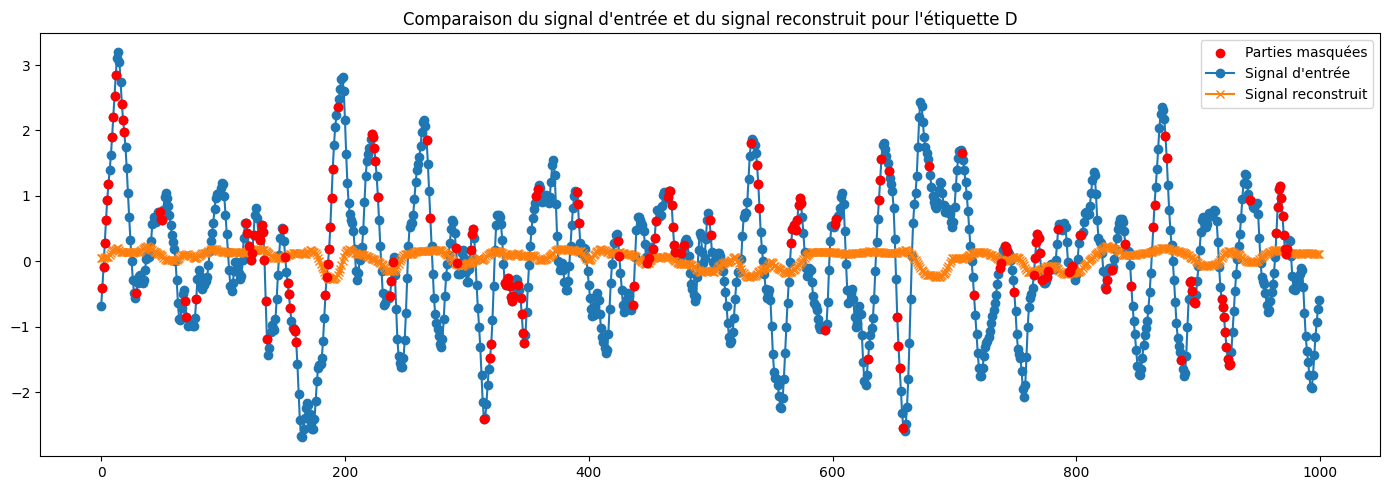

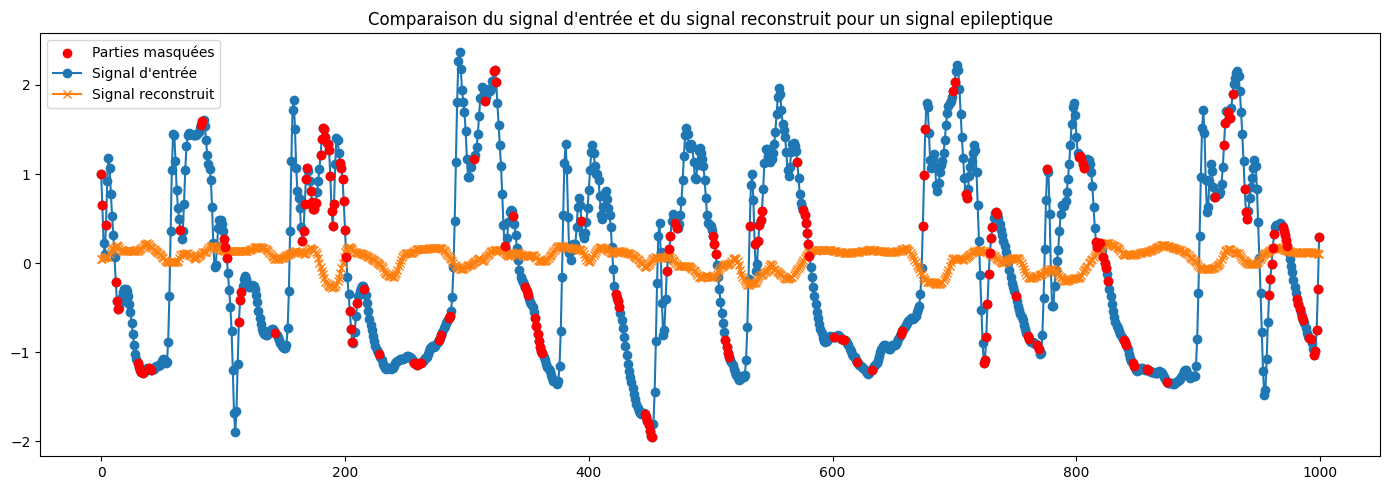

Epoch 1: Train Loss: 4.428646, Valid Accuracy: 0.537500, With Threshold: 1.020000


Epoch 2/25 [Validation]: 100%|██████████| 80/80 [00:03<00:00, 25.80it/s]


Epoch 2: Train Loss: 1.899780, Valid Accuracy: 0.562500, With Threshold: 1.000000


Epoch 3/25 [Validation]: 100%|██████████| 80/80 [00:03<00:00, 25.87it/s]


Epoch 3: Train Loss: 1.361137, Valid Accuracy: 0.575000, With Threshold: 1.000000


Epoch 4/25 [Validation]: 100%|██████████| 80/80 [00:03<00:00, 25.36it/s]


Epoch 4: Train Loss: 1.184259, Valid Accuracy: 0.650000, With Threshold: 1.000000


Epoch 5/25 [Validation]: 100%|██████████| 80/80 [00:03<00:00, 26.08it/s]


Epoch 5: Train Loss: 1.103656, Valid Accuracy: 0.587500, With Threshold: 1.000000


Epoch 6/25 [Validation]: 100%|██████████| 80/80 [00:03<00:00, 25.70it/s]


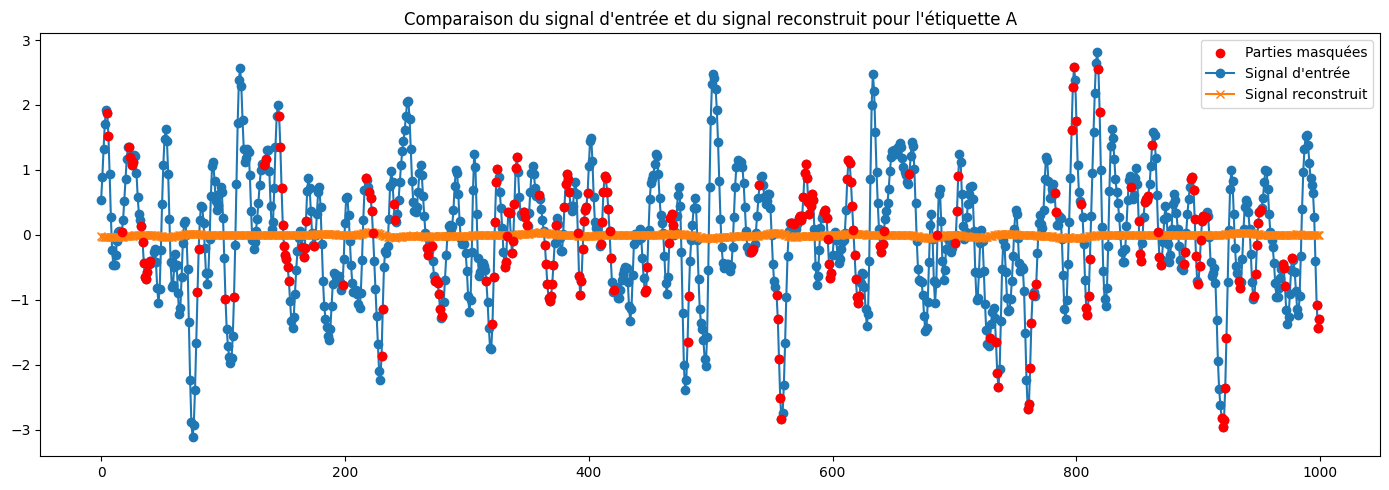

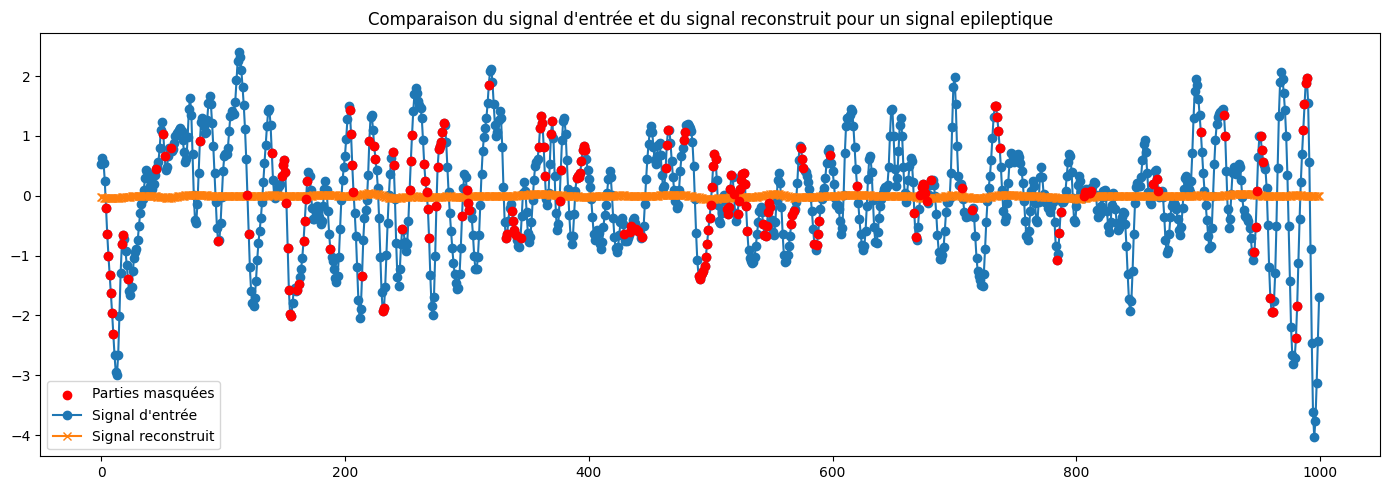

Epoch 6: Train Loss: 1.062691, Valid Accuracy: 0.575000, With Threshold: 1.000000


Epoch 7/25 [Validation]: 100%|██████████| 80/80 [00:03<00:00, 26.08it/s]


Epoch 7: Train Loss: 1.039673, Valid Accuracy: 0.550000, With Threshold: 1.000000


Epoch 8/25 [Validation]: 100%|██████████| 80/80 [00:03<00:00, 25.97it/s]


Epoch 8: Train Loss: 1.026570, Valid Accuracy: 0.562500, With Threshold: 1.000000


Epoch 9/25 [Validation]: 100%|██████████| 80/80 [00:03<00:00, 25.96it/s]


Epoch 9: Train Loss: 1.017958, Valid Accuracy: 0.537500, With Threshold: 0.990000


Epoch 10/25 [Validation]: 100%|██████████| 80/80 [00:03<00:00, 25.51it/s]


Epoch 10: Train Loss: 1.012216, Valid Accuracy: 0.612500, With Threshold: 1.000000


Epoch 11/25 [Validation]: 100%|██████████| 80/80 [00:03<00:00, 25.98it/s]


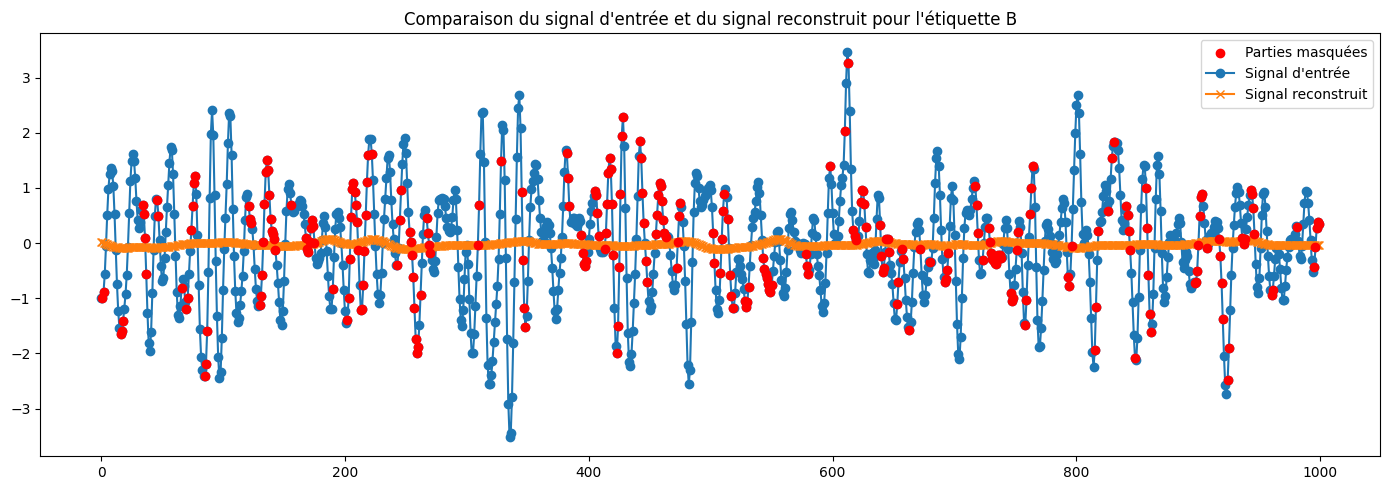

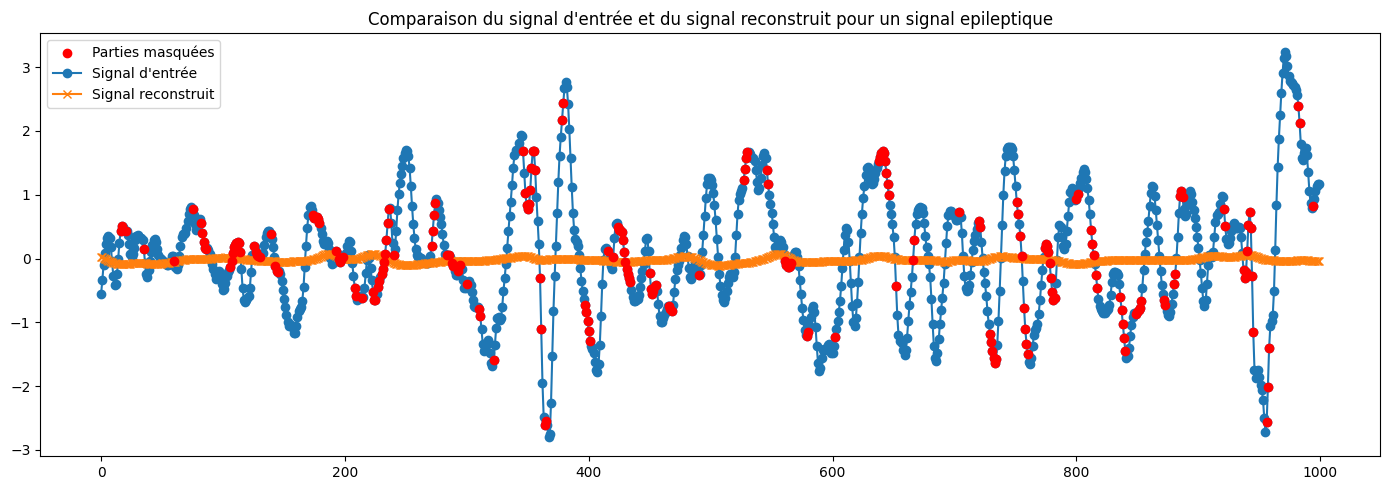

Epoch 11: Train Loss: 1.007770, Valid Accuracy: 0.612500, With Threshold: 1.000000


Epoch 12/25 [Validation]: 100%|██████████| 80/80 [00:03<00:00, 26.17it/s]


Epoch 12: Train Loss: 1.004285, Valid Accuracy: 0.587500, With Threshold: 0.990000


Epoch 13/25 [Validation]: 100%|██████████| 80/80 [00:03<00:00, 26.19it/s]


Epoch 13: Train Loss: 1.001666, Valid Accuracy: 0.612500, With Threshold: 1.000000


Epoch 14/25 [Validation]: 100%|██████████| 80/80 [00:03<00:00, 25.05it/s]


Epoch 14: Train Loss: 1.000205, Valid Accuracy: 0.637500, With Threshold: 0.990000


Epoch 15/25 [Validation]: 100%|██████████| 80/80 [00:03<00:00, 25.75it/s]


Epoch 15: Train Loss: 0.989408, Valid Accuracy: 0.800000, With Threshold: 0.990000


Epoch 16/25 [Validation]: 100%|██████████| 80/80 [00:03<00:00, 25.71it/s]


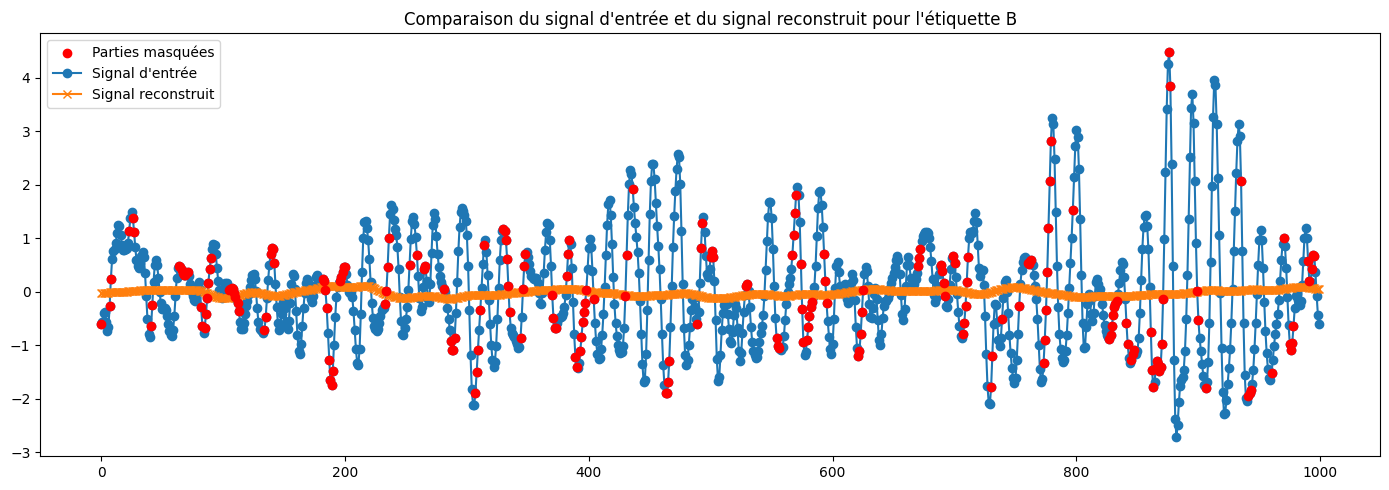

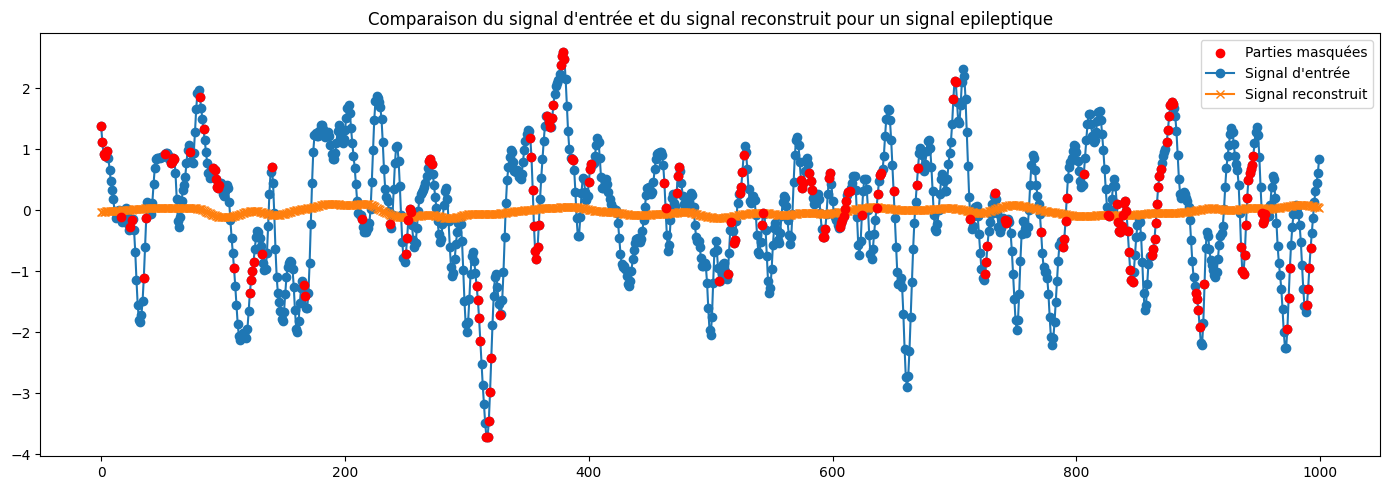

Epoch 16: Train Loss: 0.950503, Valid Accuracy: 0.837500, With Threshold: 0.970000


Epoch 17/25 [Validation]: 100%|██████████| 80/80 [00:03<00:00, 25.78it/s]


Epoch 17: Train Loss: 0.884377, Valid Accuracy: 0.800000, With Threshold: 0.910000


Epoch 18/25 [Validation]: 100%|██████████| 80/80 [00:03<00:00, 25.93it/s]


Epoch 18: Train Loss: 0.821704, Valid Accuracy: 0.775000, With Threshold: 0.840000


Epoch 19/25 [Validation]: 100%|██████████| 80/80 [00:03<00:00, 25.61it/s]


Epoch 19: Train Loss: 0.781990, Valid Accuracy: 0.737500, With Threshold: 0.780000


Epoch 20/25 [Validation]: 100%|██████████| 80/80 [00:03<00:00, 26.14it/s]


Epoch 20: Train Loss: 0.753275, Valid Accuracy: 0.737500, With Threshold: 0.810000


Epoch 21/25 [Validation]: 100%|██████████| 80/80 [00:03<00:00, 26.08it/s]


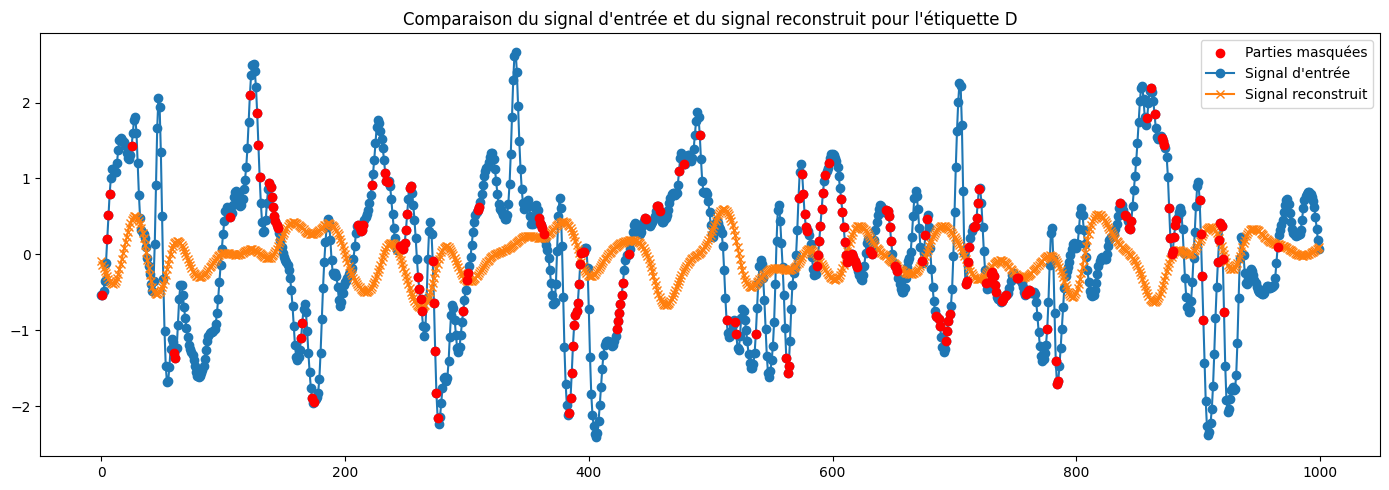

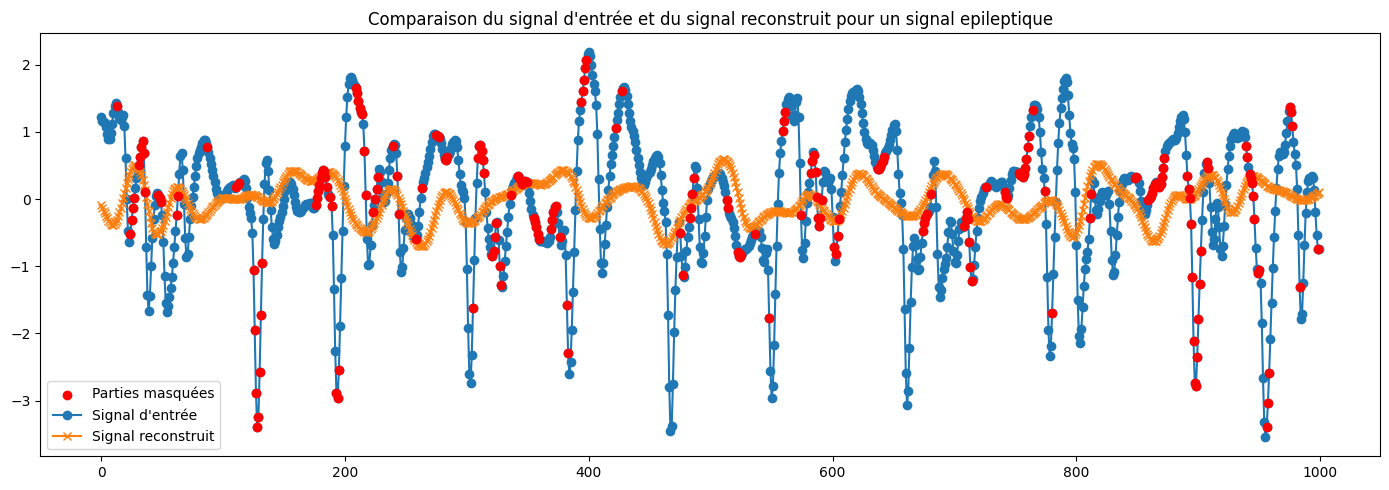

Epoch 21: Train Loss: 0.732442, Valid Accuracy: 0.700000, With Threshold: 0.760000


Epoch 22/25 [Validation]: 100%|██████████| 80/80 [00:03<00:00, 25.55it/s]


Epoch 22: Train Loss: 0.715608, Valid Accuracy: 0.700000, With Threshold: 0.540000


Epoch 23/25 [Validation]: 100%|██████████| 80/80 [00:03<00:00, 25.10it/s]


Epoch 23: Train Loss: 0.701129, Valid Accuracy: 0.687500, With Threshold: 0.470000


Epoch 24/25 [Validation]: 100%|██████████| 80/80 [00:03<00:00, 25.98it/s]


Epoch 24: Train Loss: 0.688932, Valid Accuracy: 0.712500, With Threshold: 0.470000


Epoch 25/25 [Validation]: 100%|██████████| 80/80 [00:03<00:00, 26.08it/s]

Epoch 25: Train Loss: 0.678189, Valid Accuracy: 0.712500, With Threshold: 0.430000


In [29]:
classes=['A','B','C','D','E']  

# Entraînement du modèle
learning_rate = 0.001
n_epochs = 25

# Spécification de la fonction de perte
criterion = nn.MSELoss() 

# Optimiseur
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)

# Listes pour suivre les métriques
train_losses = []

#Tableau numpy pour enregistrer les taux d'exactitude calculés sur la base de données de validation
bestaccuracies=np.zeros(n_epochs)
bestthresholds=np.zeros(n_epochs)

#Valeurs enregistrant le meilleur taux d'exactitude et le meilleur seuil
currentbestaccuracy=0
currentbestthreshold=0

best_model = None  # Stockage du meilleur modèle
best_epoch = 0  # Numéro de l'époque du meilleur modèle

# Boucle d'entraînement
for epoch in range(n_epochs):
    model.train() 
    train_loss = 0.0 
    running_mse = 0.0 

    # Barre de progression
    trainloader = tqdm(train_loader, desc=f"Epoch {epoch+1}/{n_epochs} [Training]")

    for batch_data in trainloader:
        # Décomposer les données du batch
        x_masked, mask, x_original, labels = [item.to(device).float() for item in batch_data]

        #Conversion en booléens
        mask = mask.squeeze(1).bool()

        # Réinitialiser les gradients
        optimizer.zero_grad()

        # Appel du modèle
        output, _ = model(x_masked)

        # Calcul de la perte
        loss = criterion(output, x_original) #calcul de l'erreur quadratique moyenne

        # Rétropropagation et calcul des paramètres
        loss.backward()
        optimizer.step()

        # Mise à jour des métriques
        train_loss += loss.item() * x_masked.size(0)

    # Moyenne des métriques d'entraînement
    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)

    # Étape de validation, calcul de la plus grande exactitude et son seuil correspondant
    model.eval()

    with torch.no_grad():
        labelarray=torch.zeros(len(valid_loader.dataset)) #tableau pour stocker les étiquettes
        test_losses=[] #tableau pour stocker les pertes
        validloader = tqdm(valid_loader, desc=f"Epoch {epoch+1}/{n_epochs} [Validation]")

        for i,batch_data in enumerate(validloader):
            x_masked, mask, x_original, labels = [item.to(device).float() for item in batch_data]
            output, latent_space = model(x_original)
            loss=criterion(output, x_original)

            test_losses.append(loss.item())
            labelarray[i]=labels.cpu()

        test_losses_np = np.array(test_losses) #conversion en tableau numpy de la liste
        bestthreshhold=0 #initialisation du meilleur seuil
        labelarray_np=labelarray.numpy()
        labelsbinary=(labelarray_np>4)
        bestaccuracy=0 #initialisation de la meilleure exactitude

        for j in range(200):
                predict=(test_losses_np>j*0.01) #prédiction de la classe par seuillage
                predict_true=(labelsbinary==predict) #comparaison avec les vraies étiquettes
                accuracy=predict_true.sum()/len(predict_true) #calcul de l'exactitude
                if (accuracy>bestaccuracy): 
                        bestaccuracy=accuracy #enregistrer la meilleure exactitude calculée si elle est meilleure que la précédente
                        bestthreshold=j*0.01
        
    bestaccuracies[epoch]=bestaccuracy #enregistrer la meilleure exactitude pour l'époque
    bestthresholds[epoch]=bestthreshold #enregistrer le meilleur seuil pour l'époque

    # Affichages de deux signaux, un signal épileptique, un signal non-épileptique toutes les 5 epochs
    if epoch % 5 == 0:
        index=np.random.randint(0, len(valid_loader.dataset)*0.5) #index des signaux à afficher
        for i, batch_data in enumerate(valid_loader):
            if i==index:
                x_masked, mask, x_original, labels = [item.to(device).float() for item in batch_data]
                plt.figure(figsize=(14, 5))
                masked_indices = np.where(mask.squeeze().cpu().numpy()[1000:2000] == 0)[0]
                plt.scatter(masked_indices, x_original.squeeze().cpu().numpy()[masked_indices + 1000], color='red', label='Parties masquées', zorder=3)
                plt.plot(x_original.squeeze().cpu().numpy()[1000:2000], marker='o', label='Signal d\'entrée', zorder=1)
                plt.plot(output.squeeze().cpu().numpy()[1000:2000], marker='x', label='Signal reconstruit', zorder=2)
                plt.title(f"Comparaison du signal d'entrée et du signal reconstruit pour l'étiquette {classes[int(labels.item())-1] }")
                plt.legend()
                plt.tight_layout()
                plt.show()
            if i==index*2:
                x_masked, mask, x_original, labels = [item.to(device).float() for item in batch_data]
                plt.figure(figsize=(14, 5))
                masked_indices = np.where(mask.squeeze().cpu().numpy()[1000:2000] == 0)[0] #affichage des échantillons 1000 à 2000
                plt.scatter(masked_indices, x_original.squeeze().cpu().numpy()[masked_indices + 1000], color='red', label='Parties masquées', zorder=3)
                plt.plot(x_original.squeeze().cpu().numpy()[1000:2000], marker='o', label='Signal d\'entrée', zorder=1)
                plt.plot(output.squeeze().cpu().numpy()[1000:2000], marker='x', label='Signal reconstruit', zorder=2)
                plt.title("Comparaison du signal d'entrée et du signal reconstruit pour un signal epileptique")
                plt.legend()
                plt.tight_layout()
                plt.show()

    # Affichage des résultats pour l'époque
    print(f"Epoch {epoch+1}: Train Loss: {train_loss:.6f}, Valid Accuracy: {bestaccuracy:.6f}, With Threshold: {bestthreshold:.6f}")

    # Sauvegarde du meilleur modèle
    if bestaccuracy > currentbestaccuracy:
        currentbestaccuracy = bestaccuracy
        currentbestthreshold=bestthreshold
        best_model = model.state_dict()
        best_epoch = epoch + 1




In [30]:
# Chargement et sauvegarde du meilleur modèle après l'entraînement
model.load_state_dict(best_model)
torch.save(best_model, 'best_model_'+str(latent_space.shape[1])+'_'+str(latent_space.shape[2])+'.pth')

print(f"Best model selected at epoch {best_epoch} with validation accuracy: {currentbestaccuracy:.6f}")

Best model selected at epoch 16 with validation accuracy: 0.837500


## Affichage du taux d'exactitude calculé au cours des itérations

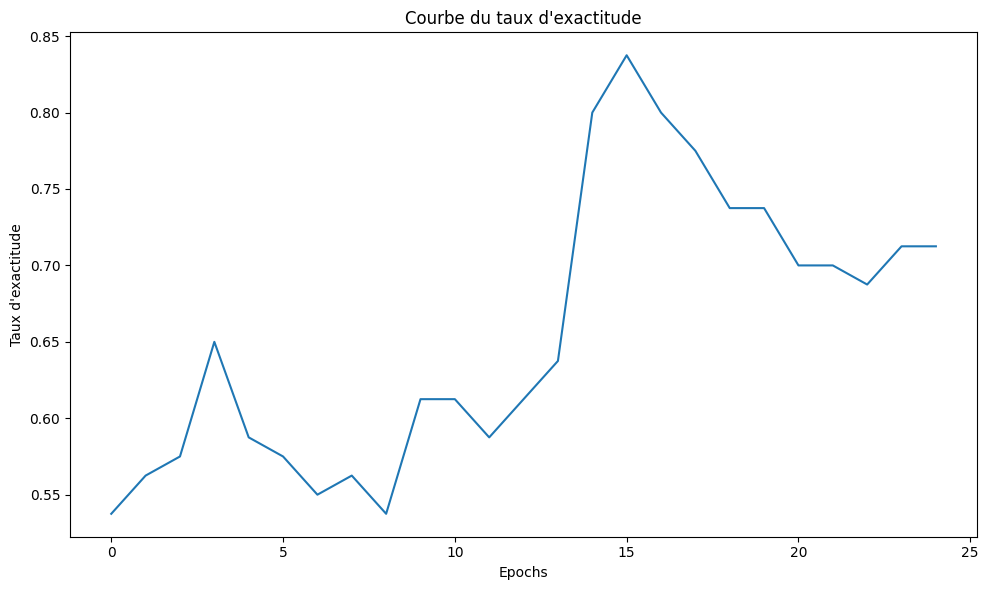

Best model selected at epoch 16 with validation accuracy: 0.837500


In [31]:
## Display train / valid curves

plt.figure(figsize=(10, 6))
plt.plot(bestaccuracies, label="Taux d'exactitude")
plt.title("Courbe du taux d'exactitude")
plt.xlabel('Epochs')
plt.ylabel("Taux d'exactitude")

plt.tight_layout()
plt.show()

print(f"Best model selected at epoch {best_epoch} with validation accuracy: {currentbestaccuracy:.6f}")

---
## Test du meilleur modèle trouvé sur la base de données test
Calcul du taux d'exactitude et du MCC

In [32]:
# Charger le best_model enregistré
model.load_state_dict(best_model)
model.eval()  # Préparer le modèle pour l'évaluation

# Initialiser les listes pour surveiller la perte de test et la précision
labelarray=torch.zeros(len(test_loader))
test_losses=[] 
for i,batch_data in enumerate(test_loader):
        x_masked, mask, x_original, labels = [item.to(device).float() for item in batch_data]
        output, latent_space = model(x_original)
        loss=criterion(output, x_original)
        test_losses.append(loss.item())
        labelarray[i]=labels.cpu() 
    
test_losses_np = np.array(test_losses)
labelarray_np=labelarray.numpy()
labelsbinary=(labelarray_np>4)  

predict=(test_losses_np>bestthreshold)
predict_true=(labelsbinary==predict)
accuracy=predict_true.sum()/len(predict_true)

#Calcul du MCC
indexN=np.where(labelsbinary==0)
indexP=np.where(labelsbinary==1)
TP=predict_true[indexP].sum()
TN=predict_true[indexN].sum()
FP=len(indexN[0])-TN
FN=len(indexP[0])-TP
MCC=(TP*TN-FP*FN)/np.sqrt((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN))

print(f"Taux d'exactitude: {accuracy:.6f}, MCC: {MCC:.6f}")
print(f"Nombre de vrais positifs: {TP}, Nombre de vrais négatifs: {TN}, Nombre de faux positifs: {FP}, Nombre de faux négatifs: {FN}")

Taux d'exactitude: 0.637500, MCC: 0.323110
Nombre de vrais positifs: 36, Nombre de vrais négatifs: 15, Nombre de faux positifs: 25, Nombre de faux négatifs: 4
